In [34]:
import pandas as pd
import numpy as np

filename = "../saved/final_dataset_cs_papers_last_20_v2.csv"

df = pd.read_csv(filename, index_col='PaperId')
df.shape

(61019, 51)

In [35]:
df.columns

Index(['Abstract', 'Author_1', 'Author_10', 'Author_11', 'Author_2',
       'Author_3', 'Author_4', 'Author_5', 'Author_6', 'Author_7', 'Author_8',
       'Author_9', 'CitationCount', 'CitationCountPerYear', 'FieldOfStudy_0',
       'FieldOfStudy_1', 'FieldOfStudy_2', 'FieldOfStudy_3', 'FieldOfStudy_4',
       'FieldOfStudy_5', 'FirstPage', 'JournalName', 'LastPage',
       'PublishedDate', 'Publisher', 'Rank', 'Title', 'YearsSincePublication',
       'AuthorProminence', 'MagBin', 'CitationBin', 'AuthorRank',
       'JournalNameRank', 'PublisherRank', 'PageCount', 'NumberOfAuthors',
       'PublicationMonth_1', 'PublicationMonth_2', 'PublicationMonth_3',
       'PublicationMonth_4', 'PublicationMonth_5', 'PublicationMonth_6',
       'PublicationMonth_7', 'PublicationMonth_8', 'PublicationMonth_9',
       'PublicationMonth_10', 'PublicationMonth_11', 'PublicationMonth_12',
       'Processed_Abstract', 'JournalNameRankNormalized',
       'PublisherRankNormalized'],
      dtype='object')

In [79]:
published_month_cols = list(df.columns[df.columns.str.startswith("Author_")])

metadata_features = [
    # Journal/Publisher
    "JournalNameRank",
    "JournalNameRankNormalized",
    "PublisherRank",
    "PublisherRankNormalized",
    # Author 
    "NumberOfAuthors",
    "AuthorRank",
    "AuthorProminence",
    # Paper features
    "PageCount"
] + published_month_cols

df_metadata = df[metadata_features]
df_normalized_cc = df["CitationCountPerYear"]

In [80]:
print(f"Max number of citations per year: {np.max(df_normalized_cc)}")
print(f"Median number of citations per year: {np.median(df_normalized_cc)}")
print(f"Mean number of citations per year: {np.mean(df_normalized_cc)}")
print(f"Std number of citations per year: {np.std(df_normalized_cc)}")

print(f"Number of papers with 0 citations: {np.sum((df_normalized_cc == 0))}")
print(f"Number papers with over 1 citation per year: {np.sum(df_normalized_cc > 1)}")
print(f"Number papers with over 5 citations per year: {np.sum(df_normalized_cc > 5)}")
print(f"Number papers with over 25 citations per year: {np.sum(df_normalized_cc > 25)}")
print(f"Number papers with over 100 citations per year: {np.sum(df_normalized_cc > 100)}")
print(f"Number papers with over 1k citations per year: {np.sum(df_normalized_cc > 1000)}")


Max number of citations per year: 1143.3305548940225
Median number of citations per year: 0.6211003970504821
Mean number of citations per year: 2.8393615494580478
Std number of citations per year: 12.939019144245327
Number of papers with 0 citations: 10686
Number papers with over 1 citation per year: 23794
Number papers with over 5 citations per year: 7443
Number papers with over 25 citations per year: 936
Number papers with over 100 citations per year: 123
Number papers with over 1k citations per year: 1


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fa758f3e670>,
                 k=None, locate_elbow=True, metric='distortion', model=None,
                 timings=True)

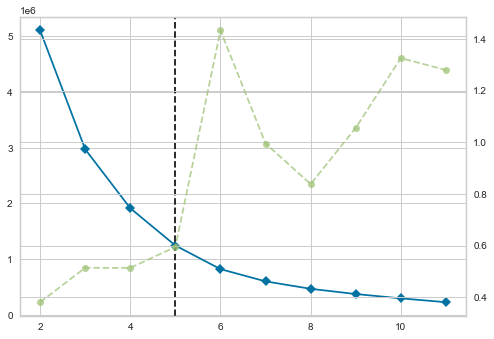

In [81]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))
visualizer.fit(df_normalized_cc.values.reshape(-1, 1))

In [111]:
from sklearn.mixture import GaussianMixture as GMM
gmm = GMM(n_components=5, random_state=0)
gmm.fit(df_normalized_cc.values.reshape(-1,1))
gmm.means_
thresholds = np.array([mu + np.sqrt(var).round() for mu, var in zip(gmm.means_, gmm.covariances_)]).flatten()
thresholds.sort()
n_bins = len(thresholds)
for i, t in enumerate(thresholds):
    print("Bin {} threshold: {}".format(i, t))

Bin 0 threshold: 0.14997276692551786
Bin 1 threshold: 2.0639298559001413
Bin 2 threshold: 7.8575842853917495
Bin 3 threshold: 25.249683302981108
Bin 4 threshold: 196.0890897163104


In [113]:
def custom_binning(y, sorted_thresholds):
    for i, threshold in enumerate(sorted_thresholds):
        if (y <= threshold):
            return i

    # Bin last threshold in the uppermost bin 
    return len(thresholds) - 1

binned_cc = pd.Series([custom_binning(y, thresholds) for y in df_normalized_cc], index=df.index)
binned_cc.shape

np.unique(binned_cc)

array([0, 1, 2, 3, 4])

[15095, 31964, 9139, 3905]


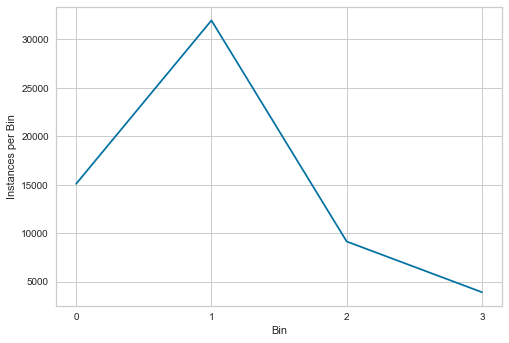

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

bins = range(len(thresholds) - 1)

instances_per_bin = [np.sum(binned_cc == b) for b in bins]
print(instances_per_bin)
fig = plt.figure()
plt.plot(bins, instances_per_bin)
plt.ylabel("Instances per Bin")
plt.xlabel("Bin")
plt.xticks(bins)
plt.show()

# Convert to binary classification and generate train, dev & test set for each threshold

Threshold = 0.14997276692551786
[15095, 45924] [0, 1]


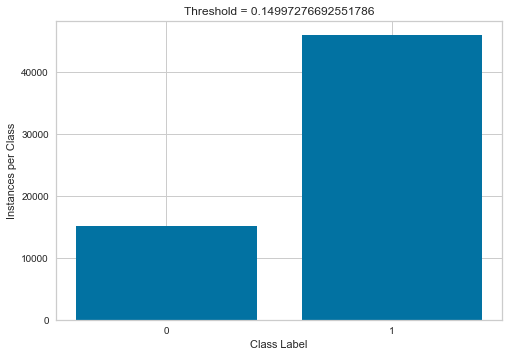

Threshold = 2.0639298559001413
[47059, 13960] [0, 1]


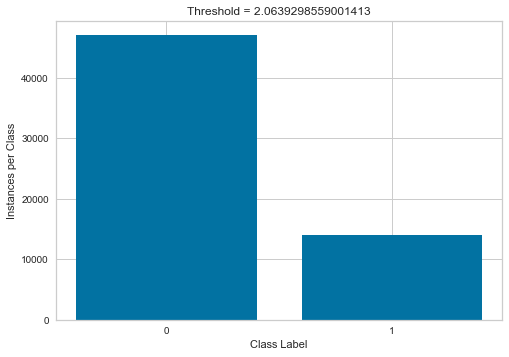

Threshold = 7.8575842853917495
[56198, 4821] [0, 1]


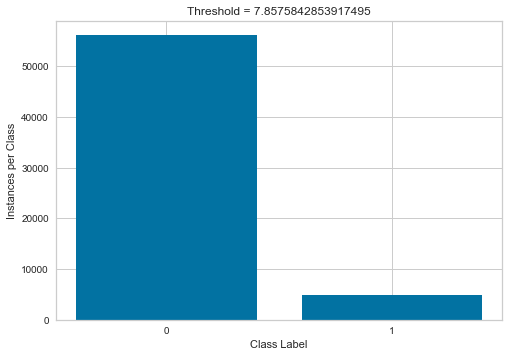

Threshold = 25.249683302981108
[60103, 916] [0, 1]


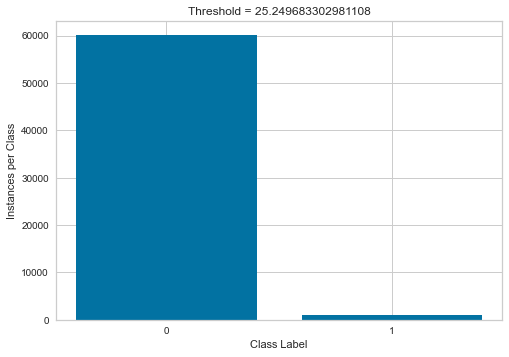

In [143]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

classes = [0, 1]
RAND_STATE = 42


X = df_metadata.copy()
directory = "../saved/final_datasets/"
X_filename = "metadata_features.csv"
X.to_csv(directory + X_filename, index_label="PaperId")

for i in bins:
    Y = binned_cc.copy()
    Y[binned_cc <= i] = 0
    Y[binned_cc > i] = 1
    
    instances_per_class = [np.sum(Y == c) for c in classes]
    threshold_str = "Threshold = {}".format(thresholds[i])
    print(threshold_str)
    print(instances_per_class, classes)
    fig = plt.figure()
    plt.bar(classes, instances_per_class)
    plt.title(threshold_str)
    plt.ylabel("Instances per Class")
    plt.xlabel("Class Label")
    plt.xticks(classes)
    plt.show()

    Y_filename = "binned_citations_threshold_{}.csv".format(i)
    Y.to_csv(directory + Y_filename, index_label="PaperId")